# Assignment 1


## Olympics

---

## Business Understanding

---

For our dataset this semester we selected the "120 years of Olympic history: athletes and results" dataset from Kaggle. This dataset tracks all Olympians' medal results from 1896-2016, as well as various physical attributes such as gender, age, weight, and height. This dataset was originally collected for various analyses, such as whether host countries' athletes win more medals, and to track the involvement of women in the Olympics from various countries over time.

Our intent this semester is to focus on analyzing the physical attributes of the Olympians over time, when they are available. We would like to determine the trends around age, height, and weight in sports over time, and whether they seem to be trending to some kind of "ideal ratio" for each sport. We would like to predict what the body types will look like in the next Olympic games, and in the Olympic Games 120 years out from now, given the current data available. For this analysis we are eliminating linear regression as a viable option, since any non-zero slope would trend to positive or negative infinity, and long-term extrapolation would quickly become absurd. We will attempt quadratic, exponential, and logarithmic regression in order to derive meaningful insights from the data. To consider our analysis "successful", our target is to explain at least 80% of the variablity in the data with our regression model, and for the 120-year prediction of height and weight to be within the realm of possibility given existing human means and standard deviations for body types.  

We would also like to see how these ratios compare to the average person in order to see which Olympic sports might be the most accessible from a body size perspective.

Finally, we would like to analyze our team members' own body types and see for which Olympic sports we might be best-suited, strictly from a height and weight perspective.

## Data Meaning Type

---

A full description of the original dataset can be found [here](https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results/home), we are focusing only on the relevant and non-reduntant fields for our analysis.

This dataset (athlete_events.csv) contains 271,116 rows. Each row corresponds to an individual athlete competing in an individual Olympic event. The columns are:

ID (Integer) - A unique number for each athlete

Name (String) - The athlete's name.

Sex (Character) - The gender of the athlete, currently either "M" or "F" in this dataset.

Age (Integer) - The age of the athlete.

Height (Integer) - The height of the athlete in centimeters.

Weight (Integer) - The weight of the athlete in kilograms.

Team (String) - The team (mainly the country) for which the athlete is participating.

Year (Integer) - The year of Olympic games, ranging from 1896-2016 in this dataset.

Season (String) - The season of Olympic Games, either "Summer" or "Winter".

City (String) - The host city of Olympic Games.

Sport (String) - The sport in which the Athlete competed.

Event (String) - The event in which the Athlete competed.

Medal (String) - The medal obtained by the athlete for this row's data, "Gold", "Silver", "Bronze", or "NA".

About 89% of the rows are missing data in at least one of these columns. This is due to records not being kept that far back in history, or for specific sports. For sports that did not track height and weight at all, we will exclude these from our analysis. For other sports that just contain missing data for some athletes we will run our analysis both by dropping the records entirely and by imputing the values using the mean for the population we are analyzing. Both of these approaches have pros and cons and we will target the approach that yields maximum statistical benefit.


## Data Quality

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
df = pd.read_csv('data/athlete_events.csv')
df.isnull().sum()

ID             0
Name           0
Sex            0
Age         9474
Height     60171
Weight     62875
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     231333
dtype: int64

In [3]:
#nacolumns = ['Age', 'Height', 'Weight', 'Medal']
#print(nacolumns[0])

#nanumlist = []

#for i in nacolumns:
#    nanum = (df[i].isnull().sum()/len(df[i]))*100
#    nanumlist.append(nanum)
    
#print(nanumlist[0]) 

agena = (df['Age'].isnull().sum()/len(df['Age'])) * 100
heightna = (df['Height'].isnull().sum()/len(df['Height'])) * 100
weightna = (df['Weight'].isnull().sum()/len(df['Height'])) * 100
medalna = (df['Medal'].isnull().sum()/len(df['Medal'])) * 100
print('Weight NA percentage: %.2f' % (agena) + '%')
print('Height NA percentage: %.2f' % (heightna) + '%')
print('Weight NA percentage: %.2f' % (weightna) + '%')
print('Medal NA percentage: %.2f' % (medalna) + '%')

Weight NA percentage: 3.49%
Height NA percentage: 22.19%
Weight NA percentage: 23.19%
Medal NA percentage: 85.33%


In [4]:
# Fill all Medal NAs with 'No Medal'
df.Medal = df.Medal.fillna('No Medal')
#list of sports with no Height/Weight listed and competed since 1936
oldsports = ['Aeronautics', 'Alpinism', 'Art Competitions','Basque Pelota', 'Cricket', 'Croquet', 'Jeu De Paume','Military Ski Patrol',
             'Motorboating','Polo', 'Racquets', 'Roque']
df['Sport'].value_counts()
#drop the 611 observations containing these sports
df = df.drop(df[df.Sport.isin(oldsports)].index)
# Impute NA values by Sex and Sport
df.Height = df.groupby(['Sex', 'Sport'])['Height'].apply(lambda x: x.fillna(x.mean()))
df.Weight = df.groupby(['Sex', 'Sport'])['Weight'].apply(lambda x: x.fillna(x.mean()))
df.Age = df.groupby(['Sex', 'Sport'])['Age'].apply(lambda x: x.fillna(x.mean()))
df.groupby(['Sex','Sport']).describe()

Age                                    \
                                 count       mean       std   min    25%   
Sex Sport                                                                  
F   Alpine Skiing               3398.0  22.334609  3.772394  14.0  20.00   
    Archery                     1015.0  26.508458  7.603019  14.0  21.00   
    Athletics                  11666.0  24.933574  4.654056  12.0  22.00   
    Badminton                    740.0  25.047297  3.942644  16.0  22.00   
    Basketball                  1256.0  25.517516  4.062619  16.0  22.00   
    Beach Volleyball             276.0  28.315217  4.133049  18.0  25.00   
    Biathlon                    1863.0  25.799249  4.050362  17.0  23.00   
    Bobsleigh                    143.0  27.832168  4.087056  19.0  25.00   
    Boxing                        72.0  26.638889  4.230358  17.0  24.00   
    Canoeing                    1380.0  25.337446  4.757658  15.0  22.00   
    Cross Country Skiing        3385.0  25.655244  4.428332  15.0  22.00   
    Curling                      222.0  29.972973  6.908529  17.0  24.25   
    Cycling                     1394.0  26.899570  5.207258  17.0  23.00   
    Diving                      1210.0  21.517677  4.168557  12.0  18.00   
    Equestrianism               1246.0  34.217846  9.009052  16.0  27.00   
    Fencing                     2000.0  26.341105  5.206464  14.0  23.00   
    Figure Skating              1172.0  20.812554  4.530487  11.0  17.00   
    Football                    1012.0  24.909091  4.090185  16.0  22.00   
    Freestyle Skiing             433.0  24.330254  4.820811  13.0  21.00   
    Golf                          70.0  27.338235  6.254529  18.0  23.00   
    Gymnastics                  9129.0  19.232751  3.982255  11.0  16.00   
    Handball                    1401.0  25.883922  4.314619  15.0  23.00   
    Hockey                      1459.0  25.332419  3.770670  15.0  23.00   
    Ice Hockey                   754.0  24.055703  4.496370  15.0  21.00   
    Judo                        1093.0  25.163769  4.054311  14.0  22.00   
    Luge                         377.0  23.649867  5.002069  15.0  20.00   
    Modern Pentathlon            164.0  25.524390  4.777826  15.0  22.00   
    Rhythmic Gymnastics          658.0  18.737082  2.505250  13.0  17.00   
    Rowing                      2193.0  25.402645  4.385894  14.0  22.00   
    Rugby Sevens                 148.0  26.114865  3.985558  18.0  23.75   
...                                ...        ...       ...   ...    ...   
M   Gymnastics                 17578.0  24.653482  4.116102  10.0  22.00   
    Handball                    2264.0  26.569902  3.988745  14.0  24.00   
    Hockey                      3958.0  25.866276  4.021011  16.0  23.00   
    Ice Hockey                  4762.0  26.114304  4.351379  16.0  23.00   
    Judo                        2708.0  25.397378  3.833503  16.0  23.00   
    Lacrosse                      60.0  26.861111  3.800771  14.0  25.00   
    Luge                        1102.0  24.960909  4.796619  16.0  22.00   
    Modern Pentathlon           1513.0  26.485616  4.013098  16.0  24.00   
    Nordic Combined             1344.0  24.342322  3.897090  15.0  22.00   
    Rowing                      8402.0  25.241112  4.291308  11.0  22.00   
    Rugby                        162.0  24.385965  2.937250  18.0  23.00   
    Rugby Sevens                 151.0  25.980132  3.563650  19.0  23.00   
    Sailing                     5660.0  30.906622  8.004672  13.0  25.00   
    Shooting                    9724.0  34.254351  8.140460  15.0  28.00   
    Short Track Speed Skating    773.0  23.141009  3.511939  15.0  20.00   
    Skeleton                     133.0  30.977099  6.827380  18.0  26.00   
    Ski Jumping                 2371.0  23.373780  4.048217  14.0  20.00   
    Snowboarding                 520.0  24.907692  4.593614  15.0  22.00   
    Speed Skating               3532.0  24.633646  4.082396  14.0  22.00   
    Swi

In [5]:

df.isnull().sum()

ID        0
Name      0
Sex       0
Age       0
Height    0
Weight    0
Team      0
NOC       0
Games     0
Year      0
Season    0
City      0
Sport     0
Event     0
Medal     0
dtype: int64

## Simple Statistics

---

In this section we will start to look at the features of our data to form thoughts on the basic shape of the data. We will look at a few rows, then the mins, maxes, means, and medians of our relevant features, and run an analysis of those values over time to see any basic trends.

In [6]:
# now lets look at the first five records of data
df.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.000000,80.000000,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,No Medal
1,2,A Lamusi,M,23.0,170.000000,60.000000,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,No Medal
2,3,Gunnar Nielsen Aaby,M,24.0,177.480339,73.086644,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,No Medal
3,4,Edgar Lindenau Aabye,M,34.0,182.480000,95.615385,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.000000,82.000000,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,No Medal


In [15]:
#Let's group like features together into continuous, ordinal, and categorical features
continuous_features = ['Height', 'Weight']
ordinal_features = ['Age']
categ_features = ['ID','Name','Sex','Team','Year','NOC','Games','City','Sport','Event','Medal']

In [16]:
#run basic summary of continuous and ordinal features
df[continuous_features+ordinal_features].describe()

,Height,Weight,Age
count,267304.000000,267304.000000,267304.000000
mean,175.543491,71.128558,25.341919
std,9.881749,13.346032,5.804288
min,127.000000,25.000000,10.000000
25%,169.000000,62.000000,21.000000
50%,176.000000,71.000000,24.653482
75%,182.000000,78.040567,28.000000
max,226.000000,214.000000,72.000000


In [17]:
#calculate the median for continuous and ordinal features
df[continuous_features+ordinal_features].median()

Height    176.000000
Weight     71.000000
Age        24.653482
dtype: float64

The heights of the Olympians in our population range from 127-226 cm with a mean of 175.54 cm and a median of 176 cm.

The weights of the Olympians in our population range from 25-214 kg with a mean of 71.13 kg and a median of 71 kg.

The ages of the Olympians in our population range from 10-72 years old with a mean of 25.34 years old and a median of 24.65 years old.


In [19]:
#Separate into two categories, greater than the mean year or less than the mean year, to see any stark differences
df[continuous_features+ordinal_features].groupby(by=df.Year>df['Year'].mean()).mean()

,Height,Weight,Age
Year,,,
False,175.256203,71.397260,25.647762
True,175.744035,70.940986,25.128422


From the means before and after the mean year for the dataset we can see that the height of olympians in the second half of the dataset seem to be slightly higher, and the weights and ages seem to be slightly lower, on average. 

Text(0,0.5,'Count')

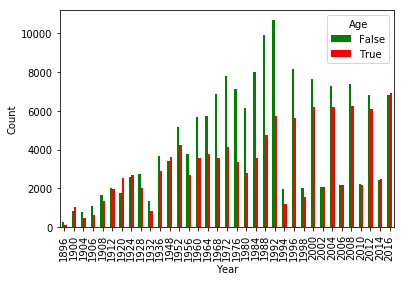

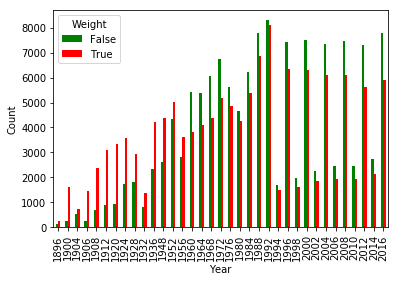

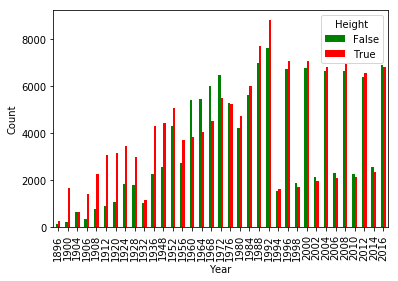

In [20]:
#plot charts of age, weight, and height over time against their means
age_over_mean = pd.crosstab([df['Year']], df.Age>df['Age'].mean())
age_over_mean.plot(kind='bar', stacked=False, color=['green','red']).set_ylabel('Count')

age_over_mean = pd.crosstab([df['Year']], df.Weight>df['Weight'].mean())
age_over_mean.plot(kind='bar', stacked=False, color=['green','red']).set_ylabel('Count')

age_over_mean = pd.crosstab([df['Year']], df.Height>df['Height'].mean())
age_over_mean.plot(kind='bar', stacked=False, color=['green','red']).set_ylabel('Count')

In the plots above we can see that for a period of 40 years from 1952-1992 the ages of athletes was steadily decreasing and were trending well below the mean age for our population. After 1992 until 2016 the ages of athletes started reversing that trend, getting older until in 2016 there was about an even split. 

For weights of athletes we see a general trend of olympians getting lighter over time. there was a period of stabilization where the weights seemed to be getting closer to the mean weight for our population, but then up to 2016 the weight decreased again to bhave a trend of weights of olympians below the mean.

Heights of employees are very interesting. At the start of our timeline athletes were almost entirely above the mean height for our population. For a brief period between 1960 and 1972 olympians were, in general, notably shorter than the mean height for our population, then that trend reversed from 1980-1992, when olympians were mostly taller than the mean, then returning close to the mean by 2016.

## Visualize Attributes

---

Todo

## Explore Joint Attributes

---

Todo

## Explore Attributes and Classes

---

Todo

## New Fe